<div>
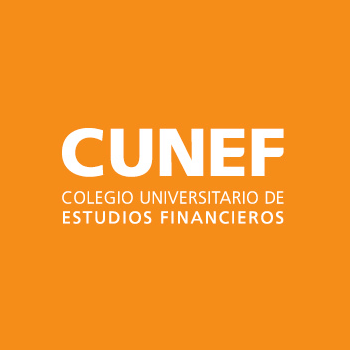
</div>

# **Matriculaciones en España**

En este notebook se mostrará la serie temporal de las **matriculaciones de vehículos en España** y observaremos cómo afectó ésta frente al COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) Análisis exploratorio
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del Excel y preparación de los datos*
Se procede a leer el archivo Excel de las matriculaciones de vehículos comerciales que han habido en España. 
- Fuente: https://datosmacro.expansion.com/negocios/matriculaciones-vehiculos/espana



In [2]:
df_matriculaciones = pd.read_excel("../data/matriculaciones.xlsx", index_col=0)
df_matriculaciones = df_matriculaciones.iloc[:,0:3]
df_matriculaciones

,Vehículos comerciales Mes,Vehículos pasajeros Mes,Venta mensual vehículos
Fecha,,,
2014-01-01,8613,53436,62052
2014-02-01,9638,68763,78401
2014-03-01,10558,79928,90485
2014-04-01,12323,80174,92497
2014-05-01,11649,82483,94132
...,...,...,...
2022-03-01,11880,59920,71534
2022-04-01,11077,69111,80188
2022-05-01,12844,84977,97652


Vamos a quedarnos de nuestro DataFrame las columnas de vehículos comerciales/mes, vehículos pasajeros/mes y la venta mensual de vehículos, que es la suma de comerciales y pasajeros. 

Entendemos por coches comerciales aquellos que son diseñados para empresas y autónomos, furgonetas y camiones destinados al trabajo, al transporte de mercancías e incluso desempeñan funciones especiales como vehículos policiales, de emergencias o ambulancias. 

## *Graficación de la serie temporal*



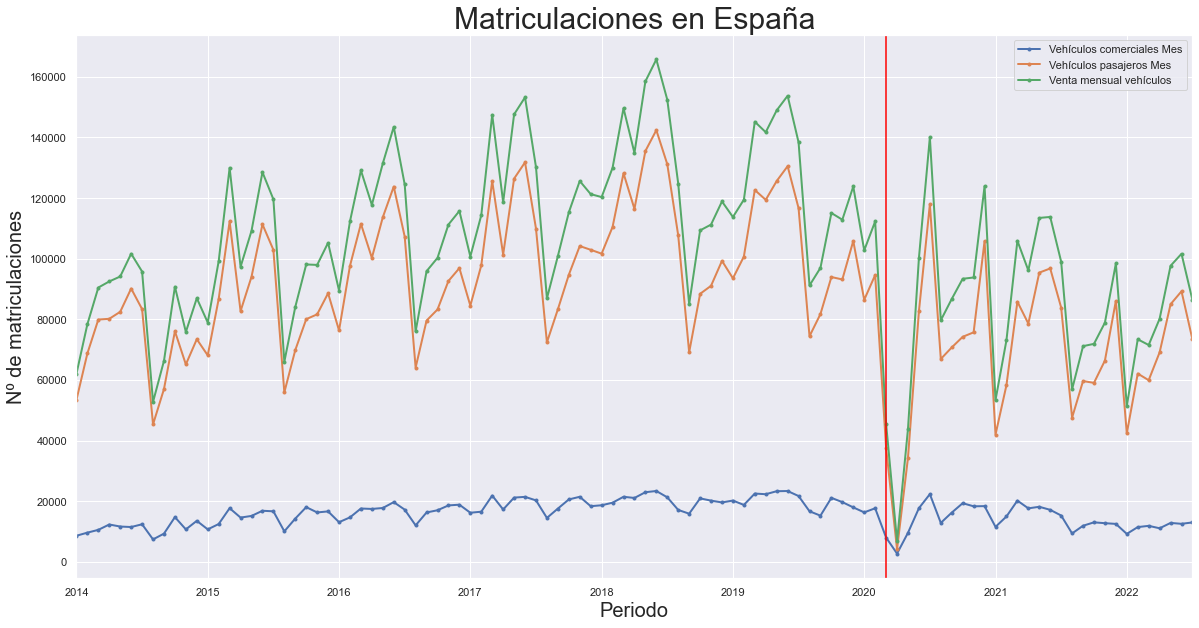

In [3]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_matriculaciones.plot(marker='.', linewidth= 2)
fig.set_title('Matriculaciones en España', fontsize = 30)
fig.set_ylabel('Nº de matriculaciones', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

Apreciamos en la gráfica que la venta mensual de vehículos es bastante similar a la serie temporal de matriculaciones de vehículos pasajeros, y **al principio sigue una tendencia creciente con altibajos marcados en los mismos meses** hasta llegar a marzo del 2020, momento en el que comienzan las restricciones por COVID-19. Lo que resulta llamativo es que realiza una caída importante en el mes de abril del 2020, y acto seguido se recuperan las matriculaciones prácticamente al mismo nivel que hubo en los últimos meses del año 2019, **aunque parece que está llevando una tendencia decreciente y aplanándose poco a poco**.

En cuanto a las matriculaciones de vehículos comerciales podemos apreciar que hay una tímida tendencia creciente hasta llegar al período COVID, donde hay una caída pero luego se vuelve a recuperar de la misma manera que con las matriculaciones de vehículos de pasajeros. 

Habiéndonos puesto ya en contexto, vamos a quedarnos solamente con la columna de **venta mensual de vehículos** para un análisis más exhaustivo.

In [4]:
df_matriculaciones = df_matriculaciones.iloc[:,-1:]
df_matriculaciones

,Venta mensual vehículos
Fecha,
2014-01-01,62052
2014-02-01,78401
2014-03-01,90485
2014-04-01,92497
2014-05-01,94132
...,...
2022-03-01,71534
2022-04-01,80188
2022-05-01,97652


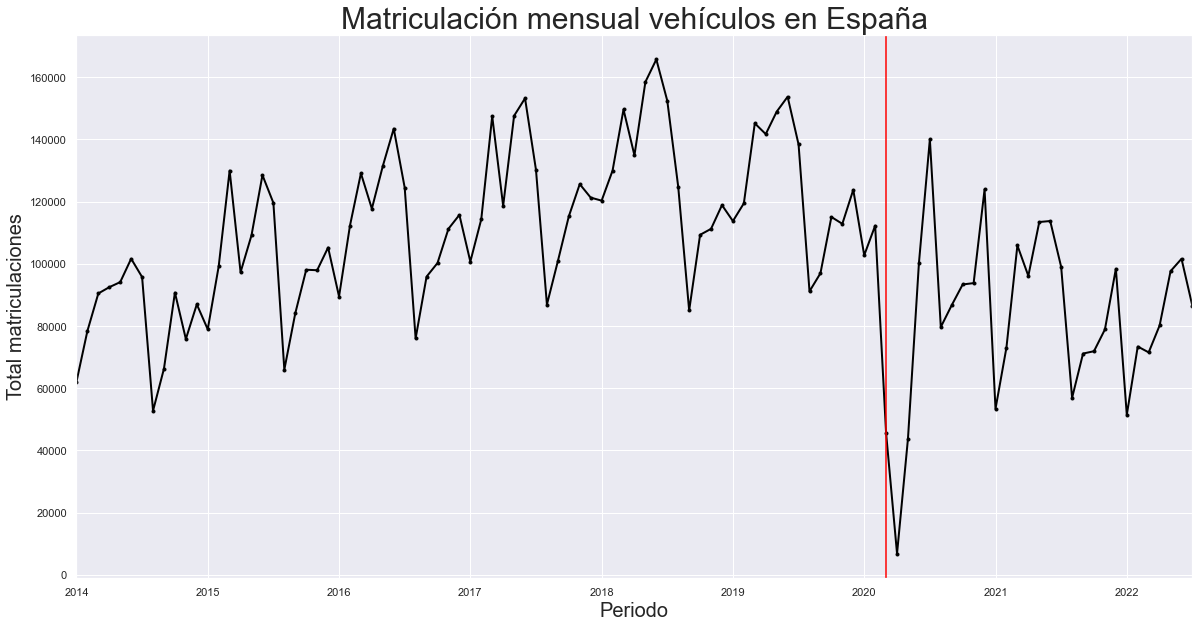

In [39]:
# Ploteamos de nuevo nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_matriculaciones['Venta mensual vehículos'].plot(marker='.', color = 'black', linewidth= 2)
fig.set_title('Matriculación mensual vehículos en España', fontsize = 30)
fig.set_ylabel('Total matriculaciones', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);
# fig.figure.savefig('../pics/df_matriculaciones/tendencias.png')

A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

Para que no nos afecte al análisis la situación anómala provocada por COVID-19, **analizaremos sólamente hasta el último mes antes del inicio de la pandemia**, esto es, **el mes de febrero del 2020**.

In [6]:
df_matriculaciones_eda=df_matriculaciones.iloc[:74,:]
df_matriculaciones_eda

,Venta mensual vehículos
Fecha,
2014-01-01,62052
2014-02-01,78401
2014-03-01,90485
2014-04-01,92497
2014-05-01,94132
...,...
2019-10-01,115075
2019-11-01,112865
2019-12-01,123821


### 3.1) Cálculo de la media y de la varianza

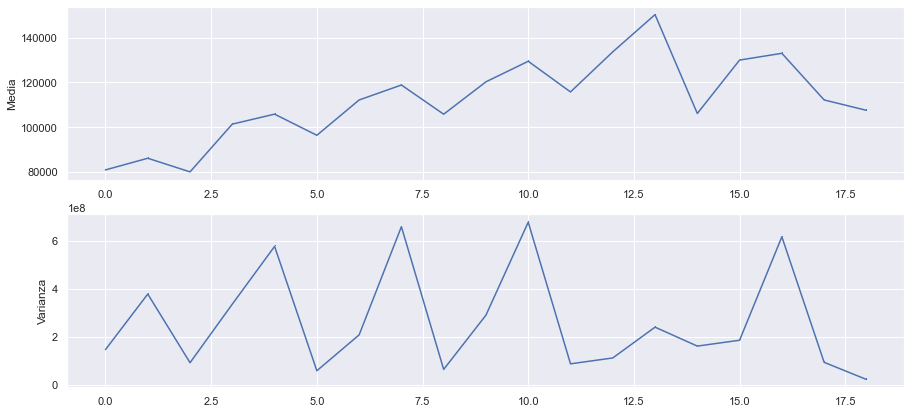

In [40]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media = split_and_summarize(df_matriculaciones_eda, 'Venta mensual vehículos', 4, np.mean)
varianza = split_and_summarize(df_matriculaciones_eda, 'Venta mensual vehículos', 4, np.var)

cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()
# fig.figure.savefig('../pics/df_matriculaciones/meanvariance.png')

A simple vista la media no es constante a lo largo del tiempo, pero la varianza no es muy clara su constancia. Vamos a observarlo con el Test de Dickey-Fuller aumentado.

### 3.2. Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [8]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_matriculaciones_eda)

Results of Dickey-Fuller Test:
Test Statistic                 -4.104346
p-value                         0.000953
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


Pues la serie temporal de matriculaciones en España **es estacionaria**, pues su p-value es menor que 0.05 y eso rechaza la hipótesis H0.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

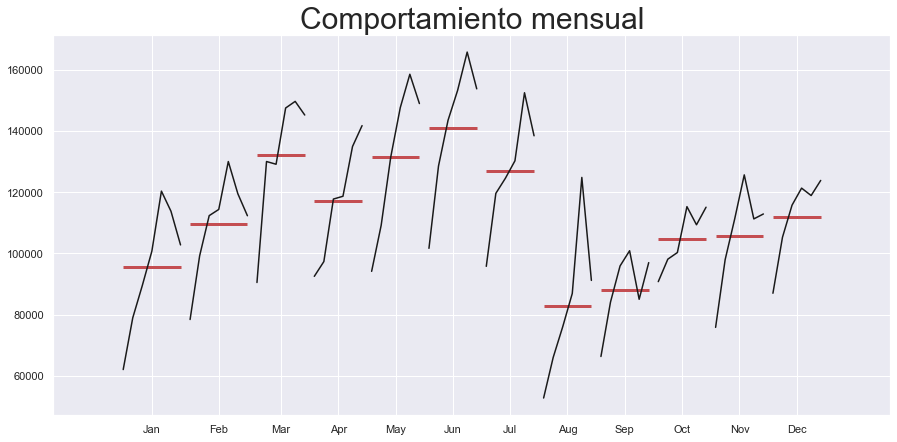

In [41]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_matriculaciones_eda['Venta mensual vehículos'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_matriculaciones/monthbehavior.png')

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

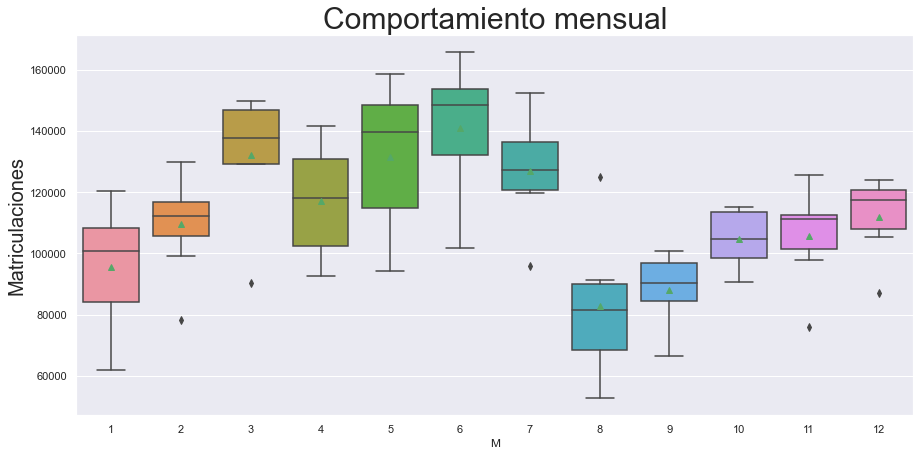

In [42]:
df_matriculaciones_eda['M'] = df_matriculaciones_eda.index.month
sns.boxplot(data = df_matriculaciones_eda, x = 'M', y='Venta mensual vehículos', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Matriculaciones', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_matriculaciones/boxplotmonth.png')

Podemos observar que los meses que más matriculaciones hay son en los 7 primeros meses del año, lo que nos indica **una estacionalidad marcada**.

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

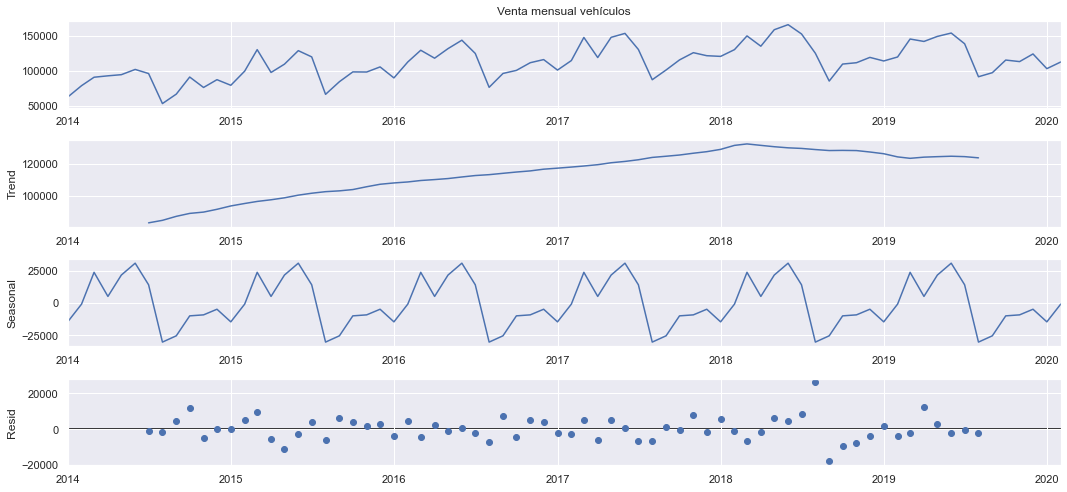

In [43]:
desglose = seasonal_decompose(df_matriculaciones_eda['Venta mensual vehículos'], 
                                   model='additive', 
                                   period=12);
desglose.plot();
# plt.savefig('../pics/df_matriculaciones/decompose.png')

Como resumen, concluimos que:

- **Hubo una ligera tendencia creciente** antes del COVID-19, luego se genera un pico de caída por motivo de la pandemia pero que luego se recupera, aunque **desde 2021 lleva una tendencia decreciente**, lo que nos quiere decir que **quizás para este sector no haya terminado el efecto COVID-19**.
- Que **es una serie estacionaria**.
- Que **existe una fuerte estacionalidad** (hasta el momento COVID)..

## *4) Estimación mediante modelos*



### 4.1) Modelo de Suavizado Exponencial (ETS)

Cantidad de períodos en Train: 74
Cantidad de períodos en Test: 29


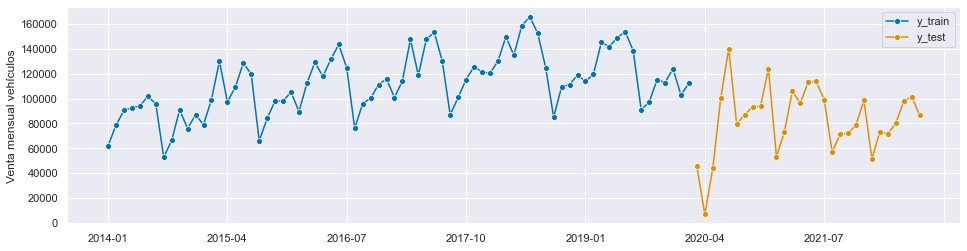

In [12]:
#Train-test
y_train,y_test=temporal_train_test_split(
    y=df_matriculaciones['Venta mensual vehículos'].astype('float64').to_period('M'),test_size=29)
# Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [13]:
y_test

2020-03     45566.0
2020-04      6833.0
2020-05     43831.0
2020-06    100217.0
2020-07    140071.0
2020-08     79676.0
2020-09     86719.0
2020-10     93374.0
2020-11     93805.0
2020-12    123941.0
2021-01     53377.0
2021-02     73099.0
2021-03    105919.0
2021-04     96131.0
2021-05    113454.0
2021-06    113774.0
2021-07     99034.0
2021-08     56923.0
2021-09     71153.0
2021-10     71909.0
2021-11     78909.0
2021-12     98425.0
2022-01     51443.0
2022-02     73417.0
2022-03     71534.0
2022-04     80188.0
2022-05     97652.0
2022-06    101624.0
2022-07     86383.0
Freq: M, Name: Venta mensual vehículos, dtype: float64

In [14]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
matriculaciones_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
matriculaciones_auto_ets.fit(y_train)
matriculaciones_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ETS Results                                    
===================================================================================
Dep. Variable:     Venta mensual vehículos   No. Observations:                   74
Model:                            ETS(MNM)   Log Likelihood                -780.023
Date:                     Tue, 06 Sep 2022   AIC                           1592.046
Time:                             15:40:47   BIC                           1628.911
Sample:                         01-31-2014   HQIC                          1606.752
                              - 02-29-2020   Scale                            0.007
Covariance Type:                    approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3762      0.098      3.835      0.000       0.184       0.568
smoothing_seasonal   6.238e-05        nan        nan        nan         nan         nan
initial_level        8.177e+04        nan        nan        nan         nan         nan
initial_seasonal.0      1.1084        nan        nan        nan         nan         nan
initial_seasonal.1      1.0528        nan        nan        nan         nan         nan
initial_seasonal.2      1.0635        nan        nan        nan         nan         nan
initial_seasonal.3      0.9003        nan        nan        nan         nan         nan
initial_seasonal.4      0.8291        nan        nan        nan         nan         nan
initial_seasonal.5      1.2726        nan        nan        nan         nan         nan
initial_seasonal.6      1.4212        nan        nan        nan         nan         nan
initial_seasonal.7      1.3309        nan        nan        nan         nan         nan
initial_seasonal.8      1.2013        nan        nan        nan         nan         nan
initial_seasonal.9      1.3631        nan        nan        nan         nan         nan
initial_seasonal.10     1.1210        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       11.09   Jarque-Bera (JB):                19.47
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.19
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [15]:
#step 5: querying predictions
matriculaciones_pred=matriculaciones_auto_ets.predict(fh=list(fh))
matriculaciones_pred.tail()

2022-03    142316.903700
2022-04    125427.243587
2022-05    138953.892683
2022-06    148383.541321
2022-07    132874.510681
Freq: M, dtype: float64

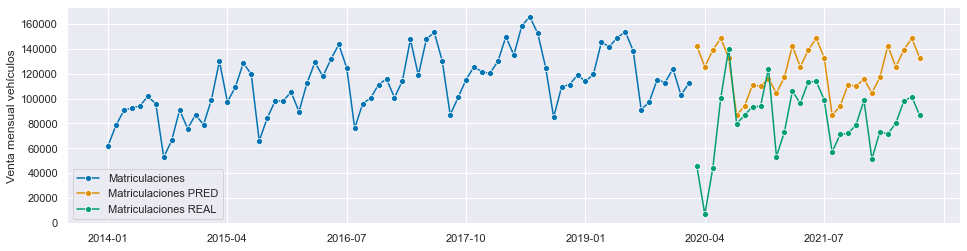

In [16]:
# optional: plotting predictions and past data
plot_series(y_train,matriculaciones_pred,y_test,
            labels=["Matriculaciones", "Matriculaciones PRED", "Matriculaciones REAL"])
plt.show()

In [17]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, matriculaciones_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 48176.82


In [18]:
mape = MeanAbsolutePercentageError(symmetric=True)
mape_ets = mape(y_test, matriculaciones_pred)
mape_ets
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 42.37%


El modelo tiene un error muy grande, probablente haya que intervenir para que el error salga con un resultado más bajo y más lógico. No obstante, vamos a continuar con los modelos.

### 4.2) Modelo ARIMA

Al tratarse de una serie estacionaria, no hace transformar la serie para obtener mejores predicciones posibles con el método de estimacion ARIMA.

Separamos el train y el test a la serie transformada con logs:

74 29


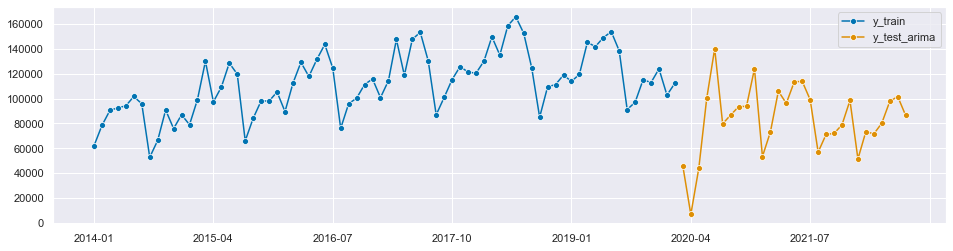

In [19]:
y_train,y_test_arima=temporal_train_test_split(
    y=df_matriculaciones.astype('float64').to_period('M').sort_index(),test_size=29)

plot_series(y_train, y_test_arima, labels=["y_train", "y_test_arima"])
print(y_train.shape[0], y_test_arima.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [20]:
fh = np.arange(1, y_test_arima.shape[0]+1)
matriculaciones_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

In [21]:
matriculaciones_auto_arima.fit(y_train)
matriculaciones_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   74
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -654.989
Date:                            Tue, 06 Sep 2022   AIC                           1317.978
Time:                                    15:40:51   BIC                           1326.422
Sample:                                         0   HQIC                          1321.287
                                             - 74                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -902.7397    373.289     -2.418      0.016   -1634.373    -171.106
ma.L1         -0.6211      0.066     -9.466      0.000      -0.750      -0.493
ma.S.L12      -0.4192      0.094     -4.470      0.000      -0.603      -0.235
sigma2      1.293e+08      0.003   4.92e+10      0.000    1.29e+08    1.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                10.32
Prob(Q):                              0.52   Prob(JB):                         0.01
Heteroskedasticity (H):               1.22   Skew:                            -0.74
Prob(H) (two-sided):                  0.67   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.19e+26. Standard errors may be unstable.
"""

In [22]:
matriculaciones_pred_arima = matriculaciones_auto_arima.predict(fh)
matriculaciones_pred_arima.round().tail()

,Venta mensual vehículos
2022-03,80660.0
2022-04,67696.0
2022-05,78050.0
2022-06,80754.0
2022-07,61885.0


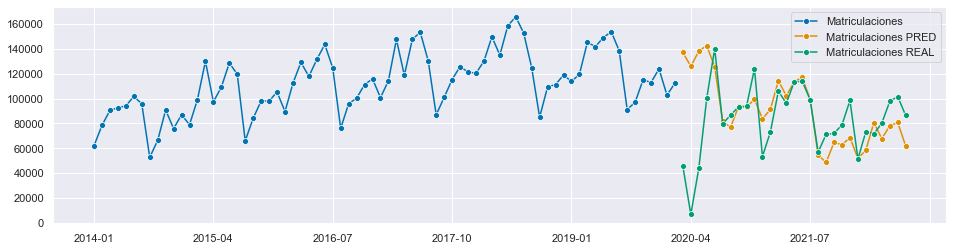

In [23]:
# representamos la serie predictiva
plot_series(y_train, matriculaciones_pred_arima, y_test_arima,
            labels=["Matriculaciones", "Matriculaciones PRED", "Matriculaciones REAL"])
plt.show()

In [24]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(y_test_arima, matriculaciones_pred_arima)
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

mape = MeanAbsolutePercentageError(symmetric=True)
mape_log = mape(y_test_arima, matriculaciones_pred_arima)
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un RMSE de: 36705.95
El modelo ARIMA genera un MAPE de: 27.29%


### Comparativa gráfica entre los modelos ETS y ARIMA

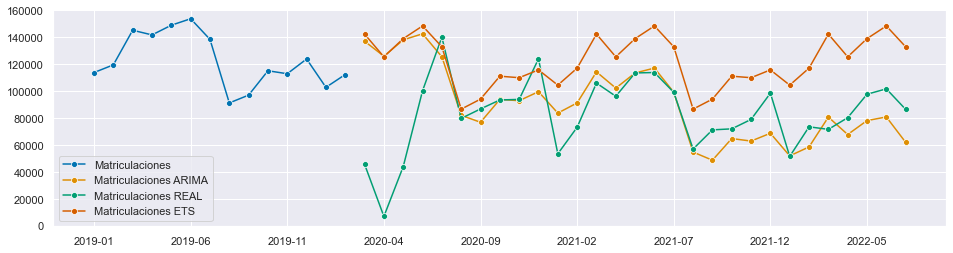

In [25]:
plot_series(y_train["2019":],matriculaciones_pred_arima,y_test_arima,
            matriculaciones_pred,labels=['Matriculaciones','Matriculaciones ARIMA',
                                         'Matriculaciones REAL','Matriculaciones ETS'])
plt.show();
# plt.savefig('../pics/df_matriculaciones/etsarima.png')

Los modelos aquí son muy parejos prediciendo pero falla bastante si no intervenimos. Se aprecia que el momento en el que coinciden los datos predictivos con los reales fue en el mes de agosto del 2020, aunque luego se vuelve algo impredecible los pronósticos. Probaremos con Prophet y si también da mucho fallo, intervenimos sobre esa fecha de agosto de 2020. 

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [26]:
prophet_train = df_matriculaciones.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [27]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

74

In [28]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing


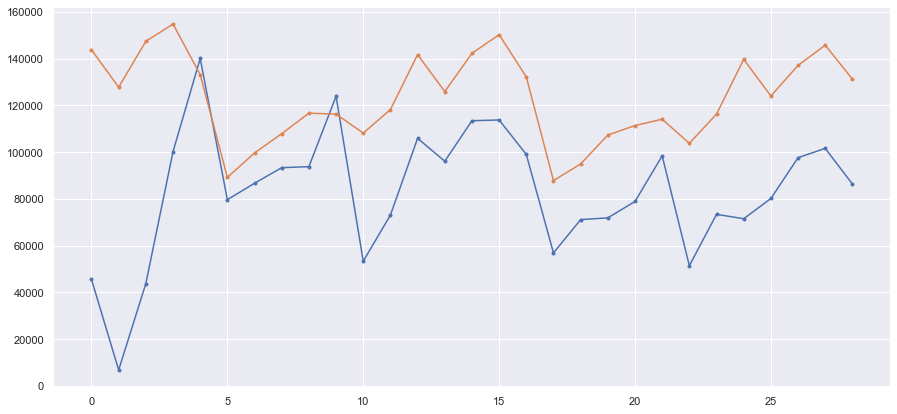

In [29]:
m = Prophet()
m.fit(prophet_y_train)

m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[74:, 'yhat']), '.-', label='Prediction')
plt.show()

In [30]:
# Forecast Accuracy
# MAPE

mape = MeanAbsolutePercentageError(symmetric=True)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un MAPE de: 43.01%
El modelo Prophet genera un RMSE de: 49234.02


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [31]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 48176.82
El modelo ARIMA genera un RMSE de: 36705.95
El modelo Prophet genera un RMSE de: 49234.02


2) MAPE (Error porcentual)

In [32]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 42.37%
El modelo ARIMA genera un MAPE de 27.29%
El modelo Prophet genera un MAPE de 43.01%


Aquí **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que menor error da, aunque da errores muy altos.
Esto significa que el efecto COVID no ha acabado, por tanto hacer una intervención no tendría ningún sentido. 

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [33]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_matriculaciones.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [34]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  103
Model:                       ETS(MNM)   Log Likelihood               -1155.083
Date:                Tue, 06 Sep 2022   AIC                           2342.166
Time:                        15:40:56   BIC                           2384.321
Sample:                    01-31-2014   HQIC                          2359.240
                         - 07-31-2022   Scale                            0.031
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1622      0.026      6.280      0.000       0.112       0.213
smoothing_seasonal   8.378e-05        nan        nan        nan         nan         nan
initial_level   

In [35]:
# Predicción del desempleo para los próximos 6 meses:
matriculaciones_pred = autoets_predict.predict(fh=list(fh))
matriculaciones_pred.round()

,Venta mensual vehículos
2022-08,58813.0
2022-09,64028.0
2022-10,73290.0
2022-11,73714.0
2022-12,82743.0


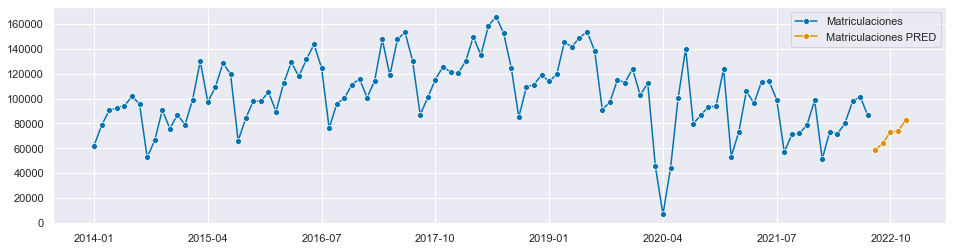

In [36]:
# Representamos gráficamente:
plot_series(y, matriculaciones_pred, labels=["Matriculaciones", "Matriculaciones PRED"])
plt.show()

In [37]:
# Guardado a fichero CSV
matriculaciones_pred.to_csv('../predictions/matriculaciones.csv')

A continuación, en el Notebook "df_matriculaciones_new" realizaremos una intervención quitando el momento COVID-19 para comprobar cuánta de diferencia hay en la precisión de la predicción cuando no hay un momento atípico.

